In [1]:
import os, sys
import dotenv
dotenv.load_dotenv('../.env')

import numpy as np
import torch
import pandas as pd
from scipy.stats import kendalltau, pearsonr, spearmanr
import pandas as pd
from torchvision import transforms

import wandb
from collections import defaultdict
import json
from pathlib import Path
from tqdm import tqdm
from copy import deepcopy
import warnings

sys.path.append('../')
from common import OnnxModel, BOLT_DIR
from metrics.metrics import calculate_open_loop_metrics, calculate_closed_loop_metrics
from dataloading.nvidia import NvidiaElvaDataset, NvidiaDataset

WANDB_ENTITY = os.getenv('WANDB_ENTITY')
WANDB_PROJECT = os.getenv('WANDB_PROJECT')

In [2]:
def are_locations_close(loc_a, loc_b, threshold=50):
    return np.linalg.norm(loc_a - loc_b) < threshold

def get_closest_frame_by_loc(df, target_loc):
    locations = df[['position_x', 'position_y']].to_numpy().astype(np.float32)
    df['distance_to_target'] = np.linalg.norm(locations - target_loc)
    return df.loc[df['distance_to_target'].idxmin()]

def get_closest_row_idx_by_timestamp(df, dt):
    df['timestamp'] = pd.to_datetime(df['index'])
    return (abs(df['timestamp'] - dt)).idxmin()

def get_longest_intervention_periods(df):
    df['autonomous_next'] = df['autonomous'].shift(-1)
    starts_ends_df = df[(df['autonomous'] & (df['autonomous_next'] == False)) | ((df['autonomous'] == False) & df['autonomous_next'])]
    starts_ends = [row['row_id'] for i, row in starts_ends_df.iterrows()]
    starts = np.array(starts_ends)[::2]
    ends = np.array(starts_ends)[1::2]
    longest_idxs = np.argsort(ends - starts)
    return (starts[longest_idxs], ends[longest_idxs])

def split_back_forth_drive_into_two(dataset):

    frames_df = dataset.frames
    vehicle_cmd_df = dataset.vehicle_cmd_frames
    # find the longest intervention period
    found_direction_change = False
    for forward_end, forward_start in zip(*get_longest_intervention_periods(frames_df)):
        if are_locations_close(frames_df[frames_df['row_id'] == forward_end][['position_x', 'position_y']].to_numpy(), track_direction_change_location) or \
            are_locations_close(frames_df[frames_df['row_id'] == forward_start][['position_x', 'position_y']].to_numpy(), track_direction_change_location):
            found_direction_change = True
            break

    if not found_direction_change:
        print('Couldn\'t find the longest intervention in the track direction change location')
        return None

    # split the drive into two
    df1 = frames_df[frames_df['row_id'] <= forward_end]
    df2 = frames_df[frames_df['row_id'] > forward_start]

    forward_end_ts = pd.to_datetime(df1.iloc[-1]['index'])
    backward_start_ts = pd.to_datetime(df2.iloc[0]['index'])

    forward_end_idx = get_closest_row_idx_by_timestamp(vehicle_cmd_df, forward_end_ts)
    backward_end_idx = get_closest_row_idx_by_timestamp(vehicle_cmd_df, backward_start_ts)

    df1_vehicle_cmd = vehicle_cmd_df.iloc[:forward_end_idx]
    df2_vehicle_cmd = vehicle_cmd_df.iloc[backward_end_idx:]

    # save the pandas dataframes back into NvidiaDataset objects
    dataset_forward = deepcopy(dataset)
    dataset_backward = deepcopy(dataset)
    dataset_forward.frames = df1
    dataset_forward.vehicle_cmd_frames = df1_vehicle_cmd
    dataset_backward.frames = df2
    dataset_backward.vehicle_cmd_frames = df2_vehicle_cmd

    return dataset_forward, dataset_backward

In [3]:
track_direction_change_location = np.array([-9683.68050786, -1542.68155186])
root_path = Path(BOLT_DIR) / 'end-to-end/drives-ebm-paper'
expert_ds = NvidiaDataset([root_path / '2021-10-26-10-49-06_e2e_rec_ss20_elva_eval_chunk'])
expert_back_ds = NvidiaDataset([root_path / '2021-10-26-11-08-59_e2e_rec_ss20_elva_back_eval_chunk'])

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2021-10-26-10-49-06_e2e_rec_ss20_elva_eval_chunk: length=13858, filtered=2
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2021-10-26-11-08-59_e2e_rec_ss20_elva_back_eval_chunk: length=14249, filtered=1


In [4]:
df = pd.read_csv('ebm-experiments-final-results.csv')
# convert str to tuple
df['drive'] = df['drive'].apply(lambda x: tuple(x[1:-1].replace('\'', '').split(',')))
df['drive'] = df['drive'].apply(lambda x: [i.strip() for i in x if i != ''])
df

,training_run,model_name,real_interventions,drive,elva_mae,elva_whiteness,elva_expert_whiteness,val_mae,model_type,traj_mae,traj_rmse,traj_max,traj_failure_rate,distance,distance_per_intervention,whiteness,cmd_whiteness,expert_whiteness
0,3ftnqxcb,ebm-512-s1,4,[ebm-paper-ebm-512-s1-forward_2022-09-21-10-51...,7.487386,191.060638,17.679368,8.607146,pilotnet-ebm,0.502133,0.617828,1.716365,10.592712,8479.229138,2119.807285,35.247937,176.928088,17.655094
1,3ftnqxcb,ebm-512-s1,1,[ebm-paper-ebm-512-s1-forward_2022-09-22-11-02...,7.487386,191.060638,17.679368,8.607146,pilotnet-ebm,0.449918,0.564381,1.713574,8.773010,8535.219556,8535.219556,32.340420,96.937671,17.655094
2,3ftnqxcb,ebm-512-s1,2,[ebm-paper-ebm-512-s1-forward_2022-09-23-11-18...,7.487386,191.060638,17.679368,8.607146,pilotnet-ebm,0.482874,0.592681,1.718401,9.072609,8519.657455,4259.828728,28.570325,223.588494,17.655094
3,3jk7cnqa,ebm-normal-1-s1,5,[e2e-ebm-normal-1-s1-day1-forward_2022-09-20-1...,6.974703,152.191879,17.679368,8.437540,pilotnet-ebm,0.412358,0.524989,1.721364,5.836352,8473.096473,1694.619295,49.922412,119.390706,17.655094
4,3jk7cnqa,ebm-normal-1-s1,2,[ebm-paper-ebm-normal-1-s1-forward_2022-09-22-...,6.974703,152.191879,17.679368,8.437540,pilotnet-ebm,0.407956,0.512668,1.708277,5.597071,8473.696547,4236.848274,38.956632,137.220901,17.655094
5,3jk7cnqa,ebm-normal-1-s1,3,[ebm-paper-ebm-normal-1-s1-forward_2022-09-23-...,6.974703,152.191879,17.679368,8.437540,pilotnet-ebm,0.447816,0.552821,1.596786,7.919993,8520.976775,2840.325592,34.206305,77.275104,17.655094
6,2jvl4yhn,ebm-spatial-0-s2,5,[e2e-ebm-spatial-0-s2-day1-forward_2022-09-20-...,6.909929,125.816818,17.679368,8.738031,pilotnet-ebm,0.436406,0.548320,1.640132,6.909590,8444.219201,1688.843840,27.796907,56.328374,17.655094
7,2jvl4yhn,ebm-spatial-0-s2,5,[ebm-paper-ebm-spatial-0-s2-forward_2022-09-21...,6.909929,125.816818,17.679368,8.738031,pilotnet-ebm,0.442618,0.559457,1.509779,8.546063,8442.245854,1688.449171,46.829478,57.148334,17.655094
8,2jvl4yhn,ebm-spatial-0-s2,4,[ebm-paper-ebm-spatial-0-s2-forward_2022-09-23...,6.909929,125.816818,17.679368,8.738031,pilotnet-ebm,0.464354,0.583141,1.689208,8.905860,8466.304693,2116.576173,33.723343,56.861922,17.655094
9,bxd5wtqk,mae-s2,2,"[e2e-mae-s2-day1-forward_2022-09-20-11-25-14, ...",7.196932,54.846653,17.679368,7.828012,pilotnet,0.400974,0.504417,1.597662,5.848605,8516.510890,4258.255445,26.690530,37.836591,17.655094


In [ ]:
datasets_forward = {}
datasets_backward = {}

for i, row in tqdm(df.iterrows()):
    drives = row['drive']
    ds_forward = None
    ds_backward = None
    forward_metrics = {}
    backward_metrics = {}
    title_forward = None
    title_backward = None
    print(type(drives), drives)

    if len(drives) == 1:
        ds_combined = NvidiaDataset([root_path / drives[0]])
        if drives[0] not in ['2022-09-09-11-47-04', '2022-09-09-10-51-33-mdn-1-s1']: # interrupted single direction drives
            ds_forward, ds_backward = split_back_forth_drive_into_two(ds_combined)
            title_forward = drives[0] + ' (forward)'
            title_backward = drives[0] + ' (backward)'
        else:
            ds_forward = ds_combined
            title_forward = drives[0]
    elif len(drives) == 2:
        ds_forward = NvidiaDataset([root_path / drives[0]])
        ds_backward = NvidiaDataset([root_path / drives[1]])
        title_forward = drives[0]
        title_backward = drives[1]
    elif len(drives) == 3:
        assert '2022-08-31-15-18-55_elva_classifier_512_forward_continued' in drives[1]
        ds_forward = NvidiaDataset([root_path / drives[0], root_path / drives[1]])
        ds_backward = NvidiaDataset([root_path / drives[2]])
        title_forward = drives[0] + ' + continued'
        title_backward = drives[2]

    if ds_forward is not None and title_forward is not None:
        datasets_forward[title_forward] = ds_forward
    if ds_backward is not None and title_backward is not None:
        datasets_backward[title_backward] = ds_backward

0it [00:00, ?it/s]

<class 'list'> ['ebm-paper-ebm-512-s1-forward_2022-09-21-10-51-39', 'ebm-paper-ebm-512-s1-backward_2022-09-21-11-02-14']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-ebm-512-s1-forward_2022-09-21-10-51-39: length=17873, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


1it [00:00,  1.26it/s]

/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-ebm-512-s1-backward_2022-09-21-11-02-14: length=18309, filtered=0
<class 'list'> ['ebm-paper-classifier-512-forward_2022-09-22-11-47-18', 'ebm-paper-classifier-512-backward_2022-09-22-11-58-03']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-classifier-512-forward_2022-09-22-11-47-18: length=18334, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


2it [00:01,  1.40it/s]

/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-classifier-512-backward_2022-09-22-11-58-03: length=18259, filtered=0
<class 'list'> ['ebm-paper-ebm-512-s1-forward_2022-09-23-11-18-29', 'ebm-paper-ebm-512-s1-backwards_2022-09-23-11-07-13']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-ebm-512-s1-forward_2022-09-23-11-18-29: length=17934, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


3it [00:02,  1.35it/s]

/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-ebm-512-s1-backwards_2022-09-23-11-07-13: length=18310, filtered=0
<class 'list'> ['e2e-ebm-normal-1-s1-day1-forward_2022-09-20-13-37-56', 'e2e-ebm-normal-1-s1-day1-backward_2022-09-20-13-48-42']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-normal-1-s1-day1-forward_2022-09-20-13-37-56: length=18183, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


4it [00:03,  1.29it/s]

/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-normal-1-s1-day1-backward_2022-09-20-13-48-42: length=18696, filtered=0
<class 'list'> ['ebm-paper-ebm-normal-1-s1-forward_2022-09-22-12-15-22', 'ebm-paper-ebm-normal-1-s1-backward_2022-09-22-12-25-57']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-ebm-normal-1-s1-forward_2022-09-22-12-15-22: length=17960, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


5it [00:03,  1.32it/s]

/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-ebm-normal-1-s1-backward_2022-09-22-12-25-57: length=19279, filtered=0
<class 'list'> ['ebm-paper-ebm-normal-1-s1-forward_2022-09-23-12-28-45', 'ebm-paper-ebm-normal-1-s1-backwards_2022-09-23-12-17-08']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-ebm-normal-1-s1-forward_2022-09-23-12-28-45: length=18014, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


6it [00:04,  1.38it/s]

/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-ebm-normal-1-s1-backwards_2022-09-23-12-17-08: length=18364, filtered=0
<class 'list'> ['e2e-ebm-spatial-0-s2-day1-forward_2022-09-20-12-44-32', 'e2e-ebm-spatial-0-s2-day1-backward_2022-09-20-12-55-04']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-spatial-0-s2-day1-forward_2022-09-20-12-44-32: length=17939, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


7it [00:05,  1.36it/s]

/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-spatial-0-s2-day1-backward_2022-09-20-12-55-04: length=18375, filtered=0
<class 'list'> ['ebm-paper-ebm-spatial-0-s2-forward_2022-09-21-11-13-54', 'ebm-paper-ebm-spatial-0-s2-backward_2022-09-21-11-24-29']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-ebm-spatial-0-s2-forward_2022-09-21-11-13-54: length=17839, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


8it [00:05,  1.40it/s]

/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-ebm-spatial-0-s2-backward_2022-09-21-11-24-29: length=18328, filtered=0
<class 'list'> ['ebm-paper-ebm-spatial-0-s2-forward_2022-09-23-11-43-09', 'ebm-paper-ebm-spatial-0-s2-backwards_2022-09-23-11-31-39']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-ebm-spatial-0-s2-forward_2022-09-23-11-43-09: length=17909, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


9it [00:06,  1.45it/s]

/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-ebm-spatial-0-s2-backwards_2022-09-23-11-31-39: length=18294, filtered=0
<class 'list'> ['e2e-mae-s2-day1-forward_2022-09-20-11-25-14', 'e2e-mae-s2-day1-backward_2022-09-20-11-35-49']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-mae-s2-day1-forward_2022-09-20-11-25-14: length=18017, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


10it [00:07,  1.41it/s]

/data/Bolt/end-to-end/drives-ebm-paper/e2e-mae-s2-day1-backward_2022-09-20-11-35-49: length=18347, filtered=0
<class 'list'> ['ebm-paper-mae-s2-forward_2022-09-21-12-22-57', 'ebm-paper-mae-s2-backward_2022-09-21-12-34-47']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-mae-s2-forward_2022-09-21-12-22-57: length=18787, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


11it [00:08,  1.36it/s]

/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-mae-s2-backward_2022-09-21-12-34-47: length=18355, filtered=0
<class 'list'> ['ebm-paper-mae-s2-forward_2022-09-23-10-31-24', 'ebm-paper-mae-s2-backward_2022-09-23-10-19-55']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-mae-s2-forward_2022-09-23-10-31-24: length=17905, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


12it [00:08,  1.34it/s]

/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-mae-s2-backward_2022-09-23-10-19-55: length=18382, filtered=0
<class 'list'> ['ebm-paper-classifier-512-forward_2022-09-21-11-36-50', 'ebm-paper-classifier-512-backward_2022-09-21-11-47-38']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-classifier-512-forward_2022-09-21-11-36-50: length=18101, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


13it [00:09,  1.31it/s]

/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-classifier-512-backward_2022-09-21-11-47-38: length=18289, filtered=0
<class 'list'> ['ebm-paper-classifier-512-forward_2022-09-22-11-47-18', 'ebm-paper-classifier-512-backward_2022-09-22-11-58-03']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-classifier-512-forward_2022-09-22-11-47-18: length=18334, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


14it [00:10,  1.43it/s]

/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-classifier-512-backward_2022-09-22-11-58-03: length=18259, filtered=0
<class 'list'> ['ebm-paper-classifier-512-forward_2022-09-23-12-05-48', 'ebm-paper-classifier-512-backwards_2022-09-23-11-54-32']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-classifier-512-forward_2022-09-23-12-05-48: length=17966, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


15it [00:10,  1.42it/s]

/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-classifier-512-backwards_2022-09-23-11-54-32: length=18349, filtered=0
<class 'list'> ['ebm-paper-mdn-5-s1-forward_2022-09-21-10-29-09', 'ebm-paper-mdn-5-s1-backward_2022-09-21-10-39-43']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-mdn-5-s1-forward_2022-09-21-10-29-09: length=17849, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


16it [00:11,  1.41it/s]

/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-mdn-5-s1-backward_2022-09-21-10-39-43: length=18234, filtered=0
<class 'list'> ['ebm-paper-mdn-5-s1-forward_2022-09-22-10-38-10', 'ebm-paper-mdn-5-s1-backward_2022-09-22-10-49-36']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-mdn-5-s1-forward_2022-09-22-10-38-10: length=17961, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


17it [00:12,  1.39it/s]

/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-mdn-5-s1-backward_2022-09-22-10-49-36: length=18523, filtered=0
<class 'list'> ['ebm-paper-mdn-5-s1-forward_2022-09-23-10-55-27', 'ebm-paper-mdn-5-s1-backwards_2022-09-23-10-43-34']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-mdn-5-s1-forward_2022-09-23-10-55-27: length=18415, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


18it [00:13,  1.38it/s]

/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-mdn-5-s1-backwards_2022-09-23-10-43-34: length=18635, filtered=0


### Intersection handling

In [ ]:
display(datasets_forward)
display(datasets_backward)

{'ebm-paper-ebm-512-s1-forward_2022-09-21-10-51-39': <dataloading.nvidia.NvidiaDataset at 0x7f3bdd2ee340>,
 'ebm-paper-classifier-512-forward_2022-09-22-11-47-18': <dataloading.nvidia.NvidiaDataset at 0x7f3b58730580>,
 'ebm-paper-ebm-512-s1-forward_2022-09-23-11-18-29': <dataloading.nvidia.NvidiaDataset at 0x7f3b4d126ac0>,
 'e2e-ebm-normal-1-s1-day1-forward_2022-09-20-13-37-56': <dataloading.nvidia.NvidiaDataset at 0x7f3bdd4efcd0>,
 'ebm-paper-ebm-normal-1-s1-forward_2022-09-22-12-15-22': <dataloading.nvidia.NvidiaDataset at 0x7f3b566c6dc0>,
 'ebm-paper-ebm-normal-1-s1-forward_2022-09-23-12-28-45': <dataloading.nvidia.NvidiaDataset at 0x7f3b566c6400>,
 'e2e-ebm-spatial-0-s2-day1-forward_2022-09-20-12-44-32': <dataloading.nvidia.NvidiaDataset at 0x7f3bdd2b6220>,
 'ebm-paper-ebm-spatial-0-s2-forward_2022-09-21-11-13-54': <dataloading.nvidia.NvidiaDataset at 0x7f3c0044d130>,
 'ebm-paper-ebm-spatial-0-s2-forward_2022-09-23-11-43-09': <dataloading.nvidia.NvidiaDataset at 0x7f3b4d127550>,
 '

{'ebm-paper-ebm-512-s1-backward_2022-09-21-11-02-14': <dataloading.nvidia.NvidiaDataset at 0x7f3bdd2ee2e0>,
 'ebm-paper-classifier-512-backward_2022-09-22-11-58-03': <dataloading.nvidia.NvidiaDataset at 0x7f3b58730340>,
 'ebm-paper-ebm-512-s1-backwards_2022-09-23-11-07-13': <dataloading.nvidia.NvidiaDataset at 0x7f3c10db86a0>,
 'e2e-ebm-normal-1-s1-day1-backward_2022-09-20-13-48-42': <dataloading.nvidia.NvidiaDataset at 0x7f3b4d126c10>,
 'ebm-paper-ebm-normal-1-s1-backward_2022-09-22-12-25-57': <dataloading.nvidia.NvidiaDataset at 0x7f3b4d126070>,
 'ebm-paper-ebm-normal-1-s1-backwards_2022-09-23-12-17-08': <dataloading.nvidia.NvidiaDataset at 0x7f3b566c6a30>,
 'e2e-ebm-spatial-0-s2-day1-backward_2022-09-20-12-55-04': <dataloading.nvidia.NvidiaDataset at 0x7f3b5655ab80>,
 'ebm-paper-ebm-spatial-0-s2-backward_2022-09-21-11-24-29': <dataloading.nvidia.NvidiaDataset at 0x7f3c0044d880>,
 'ebm-paper-ebm-spatial-0-s2-backwards_2022-09-23-11-31-39': <dataloading.nvidia.NvidiaDataset at 0x7f3c0

Text(0.5, 1.0, 'stuf')

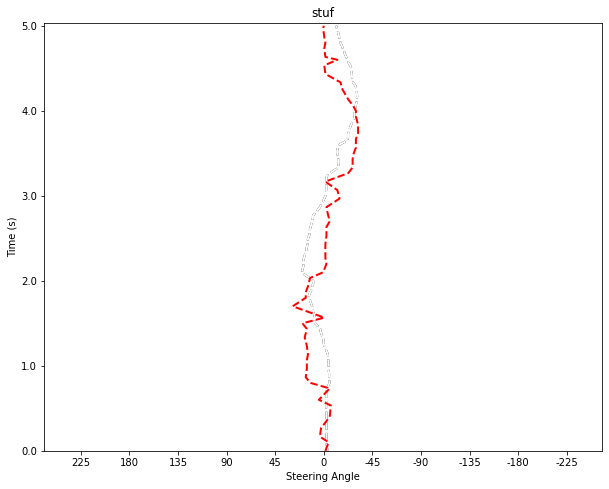

In [136]:
DURATION_SEC = 5
num_samples = 512
bound = 4.5

eff_angles = intersection_dataset.frames.steering_angle
pred_angles = intersection_dataset.frames.cmd_steering_angle * 14.7

fix, ax = plt.subplots(figsize=(10, 10))


ax.set_xlim(0, num_samples)
ax.set_ylim(DURATION_SEC*30+1, 0) # 211 = 7 seconds * 30 fps + 1
ax.set_aspect(2.6)

ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel('Steering Angle')
ax.set_ylabel('Time (s)')
tick_formatter = FuncFormatter(lambda x, pos: int(bin_idx_to_steering_angle(x, num_samples=num_samples, bound=bound).round()))
tick_locator = FixedLocator(steering_angle_to_bin_idx([-225, -180, -135, -90, -45, 0, 45, 90, 135, 180, 225]))
ax.xaxis.set_major_formatter(tick_formatter)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_locator(MultipleLocator(30))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: int(x)/30))

true_angles_indices = steering_angle_to_bin_idx(np.degrees(eff_angles), num_samples=num_samples, bound=bound)
pred_angles_indices = steering_angle_to_bin_idx(np.degrees(pred_angles), num_samples=num_samples, bound=bound)

ax.plot(true_angles_indices, np.arange(0, len(true_angles_indices)), color='white', linestyle='dashed', linewidth=2, label='Effective angle', path_effects=[pe.Stroke(linewidth=2, foreground='black'), pe.Normal()])
ax.plot(pred_angles_indices, np.arange(0, len(pred_angles_indices)), color='red', linestyle='dashed', linewidth=2, label='Model prediction')
ax.set_title('stuf')
ax.legend()

In [11]:
from ebm import optimizers
from pilotnet import PilotNet, PilotnetEBM, PilotnetClassifier, PilotnetMDN
from classifier.infer import ClassifierInferrer
from mdn.infer import MDNInferrer
from datetime import datetime
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def initialize_model(model_path, model_type, config={}):
    inference_config = None
    inference_wrapper = None

    if model_type == 'pilotnet':
        model = PilotNet()

    elif model_type == 'pilotnet-ebm':
        n_samples = config.get('n_samples', 512)
        n_dfo_iters = config.get('ebm_dfo_iters', 0)
        ebm_constant_samples = config.get('ebm_constant_samples', True)
        steering_bound = config.get('steering_bound', 4.5)
        
        inference_config = optimizers.DerivativeFreeConfig(
            bound=steering_bound,
            train_samples=n_samples,
            inference_samples=n_samples,
            iters=n_dfo_iters,
        )
        inference_wrapper = optimizers.DFOptimizerConst if ebm_constant_samples else optimizers.DFOptimizer
        model = PilotnetEBM()
        model = inference_wrapper(model, inference_config)

    elif model_type == 'pilotnet-classifier':
        steering_bound = config.get('steering_bound', 4.5)
        weights = torch.load(model_path, map_location=torch.device('cpu'))
        for _, weight in weights.items(): pass # access output layer weights
        output_layer_size = weight.shape[0]
        model = PilotnetClassifier(output_layer_size)
        model = ClassifierInferrer(model, steering_bound, output_layer_size)

    elif model_type == 'pilotnet-mdn':
        n_gaussians = config.get('n_gaussians', 5)
        old_model_version = datetime.fromtimestamp(os.stat(model_path).st_mtime) < datetime(2022, 9, 26)
        model = PilotnetMDN(n_gaussians=n_gaussians, old_version=old_model_version)
        model = MDNInferrer(model)

    else:
        raise ValueError(f'Unknown model type: {model_type}')

    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.to(device)
    model.eval()

    raw_model = model
    if model_type in ['pilotnet-mdn', 'pilotnet-classifier']:
        raw_model = model.model
    elif model_type in ['pilotnet-ebm']:
        raw_model = model.ebm

    return model, raw_model

In [79]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import dataloading.nvidia as nv

BOUND = 4.5
N_SAMPLES = 512


def get_full_model_outputs(model_name, model_type, dataloader, config={}, soft=False, temperature=1.0):
    '''Runs the torch model to extract energy/etc'''

    path_to_model = os.path.join('../_models', model_name + '.pt')

    model, raw_model = initialize_model(path_to_model, model_type, config=config)

    pred_angles = []
    pred_distributions = []

    for i, (input, target, _) in enumerate(tqdm(dataloader)):
        inputs = input['image'].to(device)
        target = target.to(device, torch.float32)

        with torch.no_grad():
            preds = model(inputs)

        if model_type == 'pilotnet-ebm':
            pred_angle = preds[0]
            energy = preds[1]
            energy = torch.squeeze(energy).cpu().detach().numpy()
            pred_distributions.append(energy)
        elif model_type == 'pilotnet-mdn':
            pred_angle = preds
            pi, sigma, mu = raw_model(inputs)
            inverted_probas = get_mdn_density(pi, sigma, mu, softmax=soft, temperature=temperature)
            inverted_probas = torch.squeeze(inverted_probas).cpu().detach().numpy()
            pred_distributions.append(inverted_probas)
        elif model_type == 'pilotnet-classifier':
            pred_angle = preds
            logits = raw_model(inputs)
            logits = torch.squeeze(logits).cpu().detach().numpy()
            pred_distributions.append(logits)
        elif model_type == 'pilotnet':
            pred_angle = preds
            pred_distributions.append([])
        
        preg_angle_cpu = pred_angle.cpu().detach().numpy()
        pred_angles.append(preg_angle_cpu)

    pred_angles = np.concatenate(pred_angles)
    true_angles = dataloader.dataset.frames.steering_angle.to_numpy()

    assert len(pred_angles) == len(true_angles), f'len(pred_angles)={len(pred_angles)} != len(true_angles)={len(true_angles)}'

    pred_distributions = np.vstack(pred_distributions)
    
    # if pred_distributions.shape[1] > 0:
    #     print(f'Model: {model_name}. Logits shape: {pred_distributions.shape}, min: {pred_distributions.min()}, max: {pred_distributions.max()}, mean: {pred_distributions.mean()}, std: {pred_distributions.std()}')

    del inputs
    del target
    del preds
    del model
    del raw_model
    torch.cuda.empty_cache()

    return pred_angles, true_angles, pred_distributions


In [13]:
import cv2

def make_video(image_paths, output_path, fps=30):
    frame = cv2.imread(image_paths[0])
    height, width, layers = frame.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_path, fourcc, fps, (width,height))
    for image_path in image_paths:
        video.write(cv2.imread(image_path))
    cv2.destroyAllWindows()
    video.release()

In [113]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator, FixedLocator
from mdn.mdn import mdn_logprob
import matplotlib.patheffects as pe
import torch.nn.functional as F


def steering_angle_to_bin_idx(angle_degs, num_samples=512, bound=4.5):
    angle_rads = np.radians(angle_degs)
    bin_idx = (angle_rads) * (num_samples-1) / (bound*2) + (num_samples-1)/2
    return bin_idx

def bin_idx_to_steering_angle(bin_idx, num_samples=512, bound=4.5):
    angle_rads = (bin_idx - (num_samples-1)/2) * bound*2 / (num_samples-1)
    angle_degs = np.degrees(angle_rads)
    return angle_degs

def get_ebm_density(energy, softmin=False, temperature=5):
    x = energy
    if softmin:
        # print('energy before softmin:', x.shape, x.min(), x.max())
        x = torch.nn.Softmin(dim=-1)(torch.tensor(energy))
        # print('energy after softmin:', x.shape, x.min(), x.max())
    x = (x - x.min()) / (x.max() - x.min())
    
    if not softmin:
        return 1 - x
    else:
        return x

def get_classifier_density(logits, softmax=False, temperature=5):
    x = logits
    if softmax:
        x = torch.nn.Softmax(dim=-1)(torch.tensor(logits)/temperature) # logits become probabilities
    x = (x - x.min()) / (x.max() - x.min()) # logits or probabilities become normalized to [0, 1]
    return x

def get_mdn_density(pi, sigma, mu, softmax=False, temperature=5):
    targets_grid = torch.linspace(-BOUND, BOUND, N_SAMPLES).repeat(pi.shape[0], 1).reshape(-1, 1).to(pi.device)
    pis_repeated = torch.repeat_interleave(pi, N_SAMPLES, dim=0)
    sigmas_repeated = torch.repeat_interleave(sigma, N_SAMPLES, dim=0)
    mus_repeated = torch.repeat_interleave(mu, N_SAMPLES, dim=0)

    logprob_density_grid = mdn_logprob(pis_repeated, sigmas_repeated, mus_repeated, targets_grid).reshape(-1, N_SAMPLES)
    x = torch.exp(logprob_density_grid)
    if softmax:
        x = torch.nn.Softmax(dim=-1)(x/temperature) 
    # x = x / x.sum(dim=-1, keepdim=True) # normalize to get probabilities
    x = (x - x.min()) / (x.max() - x.min()) # min-max scaling is no
    return x

def plot_pred_distribution(ax, pred_distribution, pred_angles, true_angles, model_type, model_label, 
                           soft=False, temperature=1, bound=4.5, num_samples=512):
    im_ratio = pred_distribution.shape[1]/pred_distribution.shape[0]
    # print('aspect ratio:', im_ratio)

    if model_type == 'pilotnet-ebm':
        mappable = ax.imshow(get_ebm_density(pred_distribution, softmin=soft, temperature=temperature), aspect=im_ratio, cmap='terrain_r')
        
    elif model_type == 'pilotnet-mdn':
        mappable = ax.imshow(pred_distribution, aspect=im_ratio, cmap='terrain_r')

    elif model_type == 'pilotnet-classifier':
        mappable = ax.imshow(get_classifier_density(pred_distribution, softmax=soft, temperature=temperature), aspect=im_ratio, cmap='terrain_r')

    elif model_type == 'pilotnet':
        mappable = None
        ax.set_xlim(0, num_samples)
        ax.set_ylim(DURATION_SEC*30+1, 0) # 211 = 7 seconds * 30 fps + 1
        ax.set_aspect(3.390728476821192)

    ax.invert_xaxis()
    ax.invert_yaxis()
    
    tick_formatter = FuncFormatter(lambda x, pos: int(bin_idx_to_steering_angle(x, num_samples=num_samples, bound=bound).round()))
    tick_locator = FixedLocator(steering_angle_to_bin_idx([-225, -180, -135, -90, -45, 0, 45, 90, 135, 180, 225]))
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.xaxis.set_major_locator(tick_locator)
    ax.yaxis.set_major_locator(MultipleLocator(30))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: int(x)/30))
    # set ticks font size to 16
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel('Steering Angle', fontsize=14)
    ax.set_ylabel('Time (s)', fontsize=14)

    true_angles = steering_angle_to_bin_idx(np.degrees(true_angles), num_samples=num_samples, bound=bound)
    pred_angles = steering_angle_to_bin_idx(np.degrees(pred_angles), num_samples=num_samples, bound=bound)
    ax.plot(true_angles, np.arange(0, len(true_angles)), color='white', linestyle='dashed', linewidth=2, label='Human-driven', path_effects=[pe.Stroke(linewidth=2, foreground='black'), pe.Normal()])

    ax.plot(pred_angles, np.arange(0, len(pred_angles)), color='red', linestyle='dashed', linewidth=2, label='Model prediction')
    ax.set_title(model_label)
    ax.legend(loc='upper right', ncol=1, facecolor='#e0e0e0', framealpha=1, prop={'size': 12})

    if mappable is not None:
        cbar = plt.colorbar(mappable, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=14)

    return mappable

In [141]:
ebm512_day_2_forward_ds = datasets_forward['ebm-paper-ebm-512-s1-forward_2022-09-21-10-51-39']
ebm512_day_2_backward_ds = datasets_backward['ebm-paper-ebm-512-s1-backward_2022-09-21-11-02-14']

intersection_dataset = crop_place(ebm512_day_2_forward_ds, ebm512_day_2_backward_ds, 'village-forward')
# frame = intersection_dataset.frames.iloc[55].image_path

make_video(intersection_dataset.frames.image_path.tolist(), 'ebm-paper-ebm-512-s1-forward_2022-09-21-10-51-39_village-forward.mp4')
# print(frame)
# !code $frame

In [16]:
PLACES = ['village-forward', 'village-backward', 'early-forward', 'early-backward', 't-intersection-forward', 't-intersection-backward', 'sharp-turn-forward']

In [103]:
model_name_to_label = {
    'classifier-512': 'Classification',
    'ebm-512-s1': 'EBM',
    'mdn-5-s1': 'MDN',
    'mae-s2': 'Regression',
    'ebm-normal-1-s1': 'EBM w/ temporal smoothing',
    'ebm-spatial-0-s2': 'EBM w/ soft targets',
    'mdn-3-s1-90-0-90': 'MDN'
}

In [18]:
from copy import deepcopy

DURATION_SEC = 5
# PLACES = ['village-forward']
# PLACES = ['t-intersection-forward', 't-intersection-backward', 'sharp-turn-forward']
# PLACES = ['village-forward', 'village-backward', 'early-forward', 'early-backward']

def crop_place(ds_forward, ds_backward, place='village-forward'):
    dataset = ds_forward if 'forward' in place else ds_backward
    intersection_ds = deepcopy(dataset)
    inter_fr = dataset.frames

    if place == 'village-forward':
        intersection_start = inter_fr[inter_fr['position_x'] < -8040].iloc[0]
    elif place == 'village-backward':
        intersection_start = inter_fr[inter_fr['position_x'] > -8085].iloc[0]
    elif place == 'early-forward':
        intersection_start = inter_fr[inter_fr['position_y'] > -3495].iloc[0]
    elif place == 'early-backward':
        intersection_start = inter_fr[inter_fr['position_x'] > -9075].iloc[0]
    elif place == 't-intersection-forward':
        intersection_start = inter_fr[inter_fr['position_y'] > -2360].iloc[0]
    elif place == 't-intersection-backward':
        intersection_start = inter_fr[inter_fr['position_x'] > -7665].iloc[0]
    elif place == 'sharp-turn-forward':
        intersection_start = inter_fr[inter_fr['position_y'] > -1800].iloc[0]

    inter_fr = inter_fr[inter_fr['row_id'] >= intersection_start['row_id']]
    inter_fr = inter_fr[inter_fr['row_id'] <= intersection_start['row_id'] + DURATION_SEC * 30]
    intersection_ds.frames = inter_fr
    return intersection_ds

In [19]:
PLACES

['village-forward',
 'village-backward',
 'early-forward',
 'early-backward',
 't-intersection-forward',
 't-intersection-backward',
 'sharp-turn-forward']

In [ ]:
DURATION_SEC = 5
STEERING_RATIO = 14.7
num_samples = 512
bound = 4.5

def make_intersection_plot(ds):

    fig, ax = plt.subplots(figsize=(10, 10))

    eff_angles = ds.frames.steering_angle
    pred_angles = ds.frames.cmd_steering_angle * STEERING_RATIO

    ax.set_xlim(0, num_samples)
    ax.set_ylim(DURATION_SEC*30+1, 0) # 211 = 7 seconds * 30 fps + 1
    ax.set_aspect(2.6)

    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_xlabel('Steering Angle')
    ax.set_ylabel('Time (s)')
    tick_formatter = FuncFormatter(lambda x, pos: int(bin_idx_to_steering_angle(x, num_samples=num_samples, bound=bound).round()))
    tick_locator = FixedLocator(steering_angle_to_bin_idx([-225, -180, -135, -90, -45, 0, 45, 90, 135, 180, 225]))
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.xaxis.set_major_locator(tick_locator)
    ax.yaxis.set_major_locator(MultipleLocator(30))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: int(x)/30))

    true_angles_indices = steering_angle_to_bin_idx(np.degrees(eff_angles), num_samples=num_samples, bound=bound)
    pred_angles_indices = steering_angle_to_bin_idx(np.degrees(pred_angles), num_samples=num_samples, bound=bound)

    ax.plot(true_angles_indices, np.arange(0, len(true_angles_indices)), color='white', linestyle='dashed', linewidth=2, label='Effective angle', path_effects=[pe.Stroke(linewidth=2, foreground='black'), pe.Normal()])
    ax.plot(pred_angles_indices, np.arange(0, len(pred_angles_indices)), color='red', linestyle='dashed', linewidth=2, label='Model prediction')
    ax.set_title('stuf')
    ax.legend()

In [ ]:
make_intersection_plot()

In [145]:
os.makedirs('videos', exist_ok=True)

for (forward_name, forward_ds), (backward_name, backward_ds) in zip(datasets_forward.items(), datasets_backward.items()):
    print(forward_name, backward_name)

    for place in PLACES:
        place_ds = crop_place(forward_ds, backward_ds, place)
        make_video(place_ds.frames.image_path.tolist(), f'videos/{forward_name}_{place}.mp4')

    break

ebm-paper-ebm-512-s1-forward_2022-09-21-10-51-39 ebm-paper-ebm-512-s1-backward_2022-09-21-11-02-14


In [87]:
intersection_dataset = crop_place(expert_ds, expert_back_ds, PLACES[2])
frame = intersection_dataset.frames.iloc[60].image_path
print(frame)
!code $frame

/data/Bolt/end-to-end/drives-ebm-paper/2021-10-26-10-49-06_e2e_rec_ss20_elva_eval_chunk/front_wide/1635235139775213003.png


### Density plots

100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Intersection "village-forward"


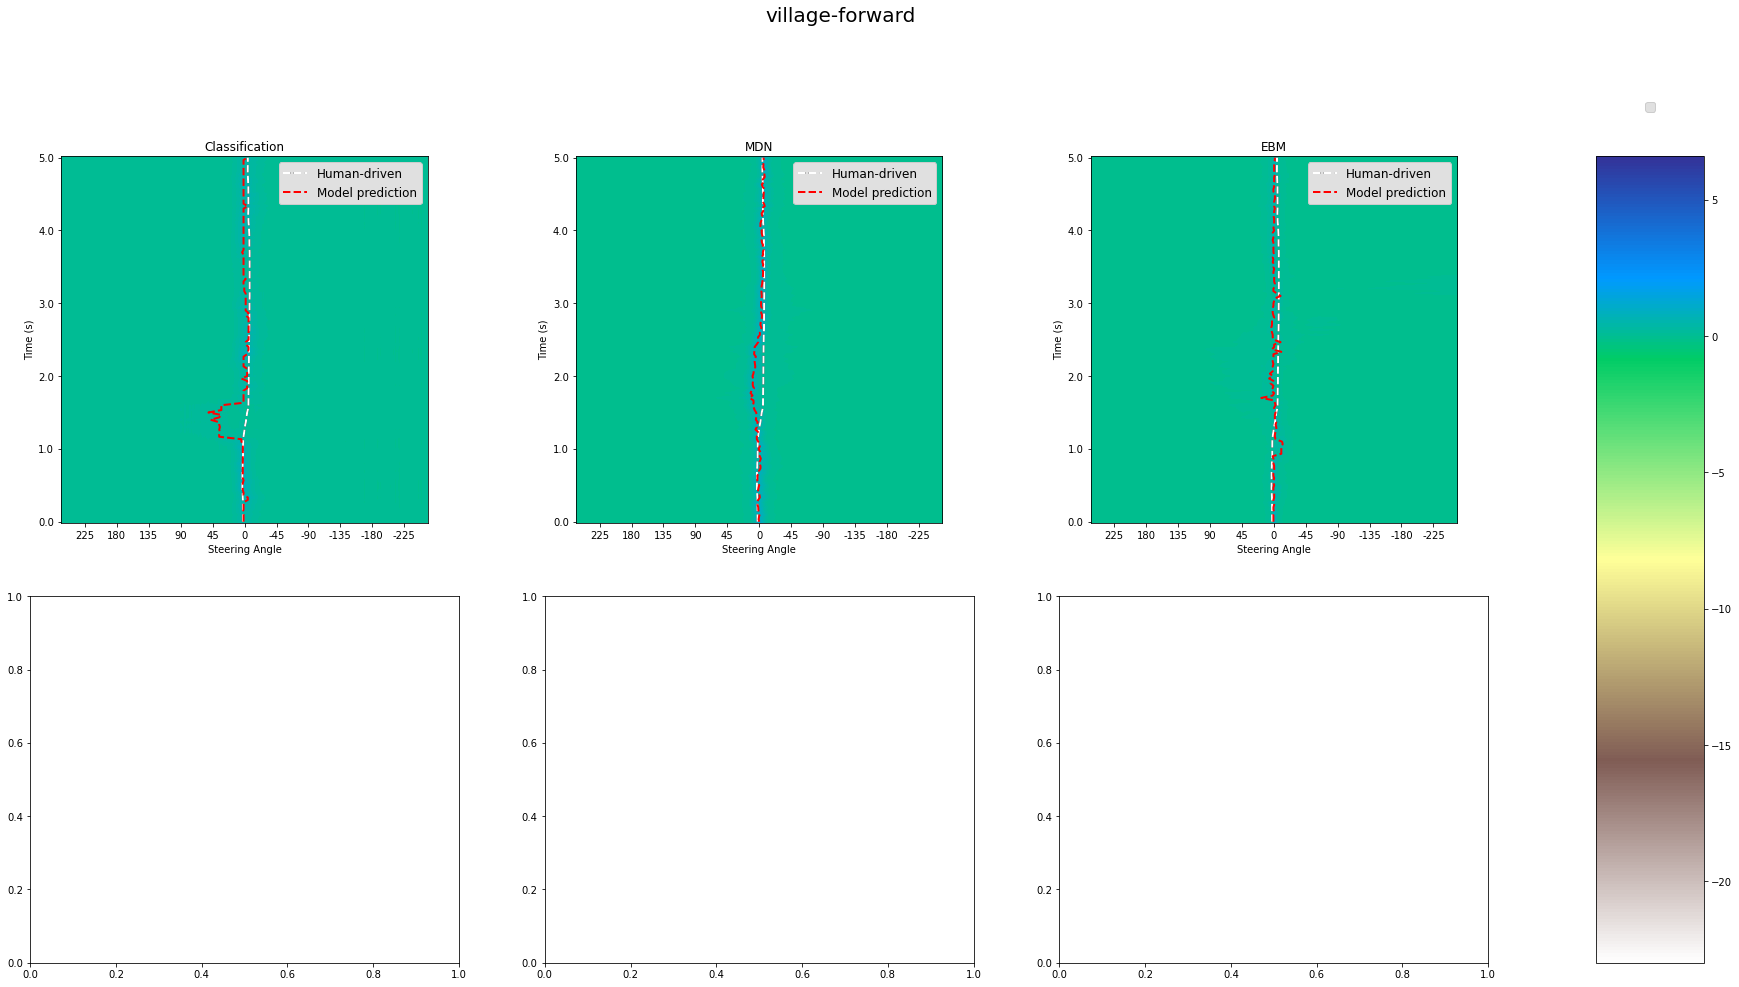

In [90]:
# prepare models
models = df.groupby('model_name').first().reset_index()[['model_name','model_type']].values
models = models[[4, 0, 5, 1, 2, 3]]
# models = models[[4, 0, 5, 1]]
# models = models[[1,2,3]]

# models = [('mae-s2', 'pilotnet', None), ('mdn-5-s1', 'pilotnet-mdn', 5), ('mdn-3-s1-90-0-90', 'pilotnet-mdn', 3), ('classifier-512', 'pilotnet-classifier', None), 
#           ('ebm-512-s1', 'pilotnet-ebm', None), ('ebm-normal-1-s1', 'pilotnet-ebm', None), ('ebm-spatial-0-s2', 'pilotnet-ebm', None)]

soft = False
temperature = 5

for intersection in PLACES[:1]:

    min_val = 9999
    max_val = -9999

    # prepare intersection dataset
    expert_ds.transform = transforms.Compose([nv.NvidiaCropWide(), nv.Normalize()])
    expert_back_ds.transform = transforms.Compose([nv.NvidiaCropWide(), nv.Normalize()])
    intersection_dataset = crop_place(expert_ds, expert_back_ds, intersection)
    loader = DataLoader(intersection_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

    # plot predictions
    fig, axes = plt.subplots(2, 3, figsize=(30, 16))
    if not hasattr(axes, '__iter__'):
        axes = np.array([axes])

    model_preds = []
    for (model_name, model_type) in models:
        pred_angles, true_angles, pred_distributions = get_full_model_outputs(model_name, model_type, loader, soft=soft, temperature=temperature)
        candidate_min_val = np.min(pred_distributions)
        candidate_max_val = np.max(pred_distributions)
        if candidate_min_val < min_val:
            min_val = candidate_min_val
        if candidate_max_val > max_val:
            max_val = candidate_max_val

        model_preds.append((model_name, model_type, pred_angles, true_angles, pred_distributions))

    for (model_name, model_type, pred_angles, true_angles, pred_distributions), ax in zip(model_preds, axes.flatten()):
        mappable = plot_pred_distribution(ax, pred_distributions, pred_angles, true_angles, model_type, 
                                            model_name_to_label[model_name], soft=soft, temperature=temperature, 
                                            vmin=min_val, vmax=max_val)

    fig.suptitle(intersection, fontsize=20)
    # add colorbar
    fig.subplots_adjust(right=0.8, hspace=0.2, wspace=0.2, bottom=0.15, top=0.85)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(mappable, cax=cbar_ax)

    # add legend
    handles, labels = axes.flatten()[-1].get_legend_handles_labels()
    cbar_ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.075), ncol=1, facecolor='#e0e0e0', framealpha=1, prop={'size': 12})

    # fig.suptitle(f'Intersection "{intersection}"')
    print(f'Intersection "{intersection}"')
    fig.show()

100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Intersection "village-forward"


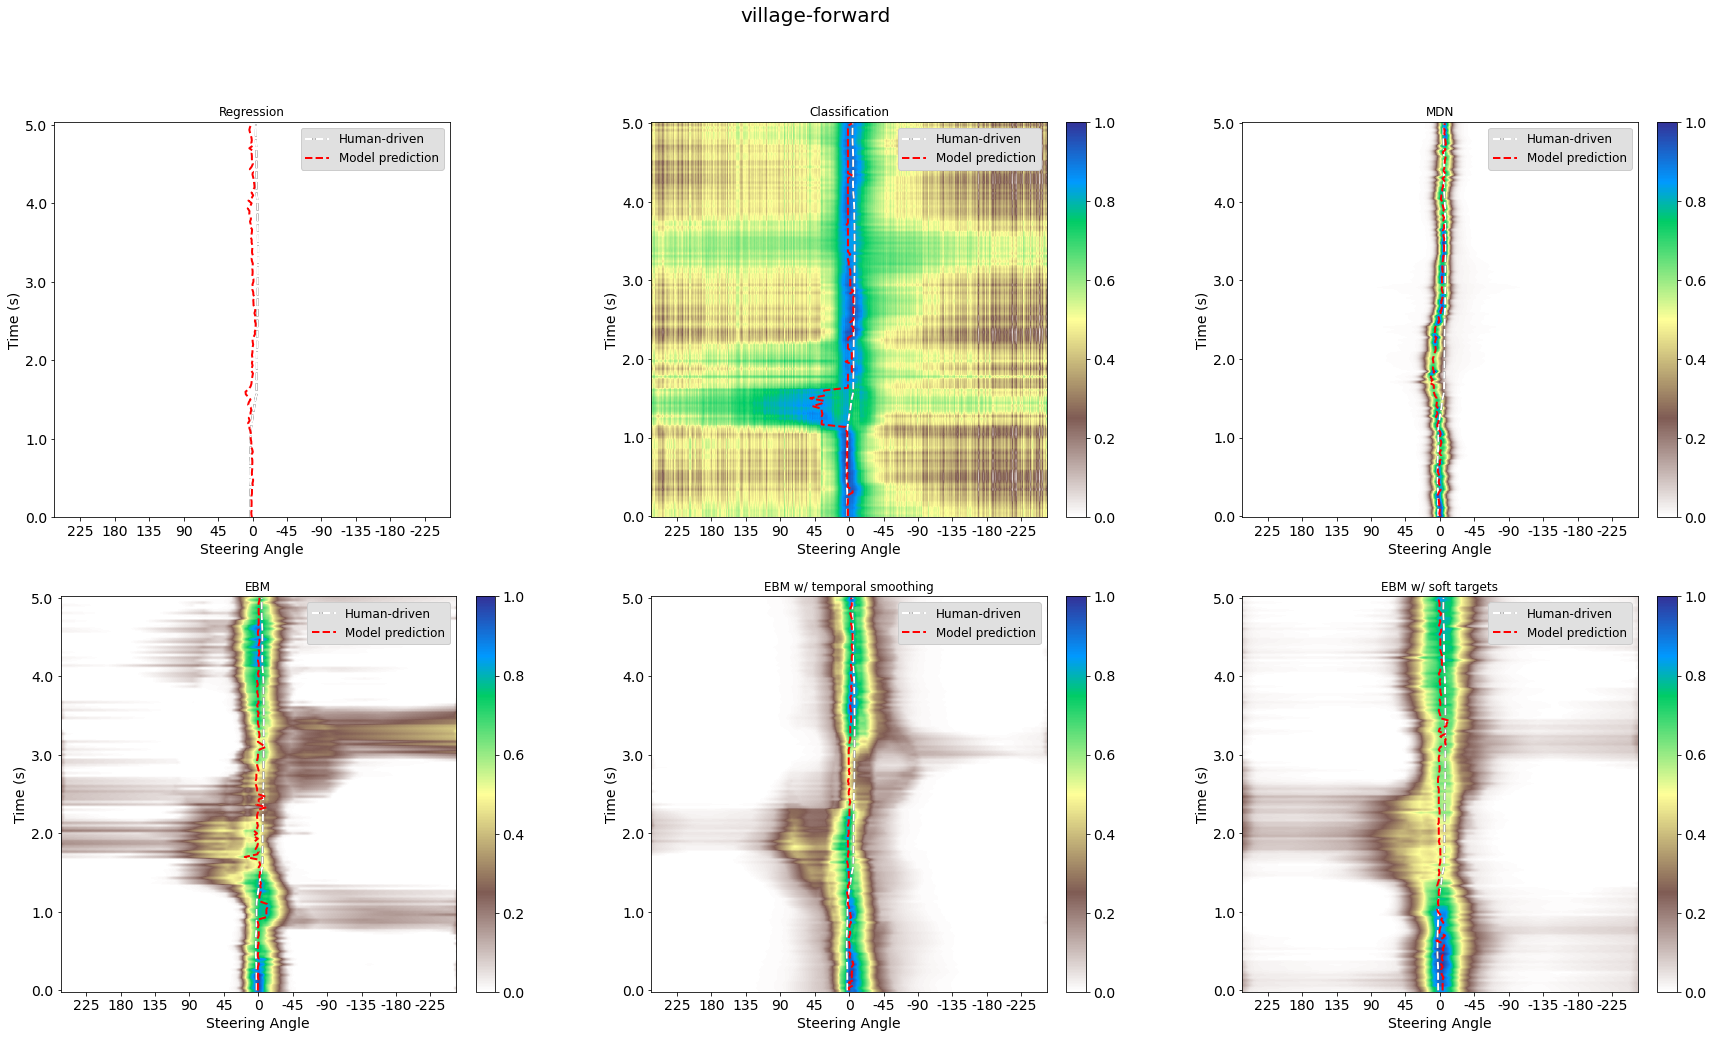

In [115]:
# prepare models
models = df.groupby('model_name').first().reset_index()[['model_name','model_type']].values
models = models[[4, 0, 5, 1, 2, 3]]
# models = models[[4, 0, 5, 1]]
# models = models[[1]]

# models = [('mae-s2', 'pilotnet', None), ('mdn-5-s1', 'pilotnet-mdn', 5), ('mdn-3-s1-90-0-90', 'pilotnet-mdn', 3), ('classifier-512', 'pilotnet-classifier', None), 
#           ('ebm-512-s1', 'pilotnet-ebm', None), ('ebm-normal-1-s1', 'pilotnet-ebm', None), ('ebm-spatial-0-s2', 'pilotnet-ebm', None)]

soft = False
temperature = 5

os.makedirs('figures', exist_ok=True)

for intersection in PLACES[:1]:

    # min_val = 9999
    # max_val = -9999

    # prepare intersection dataset
    expert_ds.transform = transforms.Compose([nv.NvidiaCropWide(), nv.Normalize()])
    expert_back_ds.transform = transforms.Compose([nv.NvidiaCropWide(), nv.Normalize()])
    intersection_dataset = crop_place(expert_ds, expert_back_ds, intersection)
    loader = DataLoader(intersection_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

    # plot predictions
    fig, axes = plt.subplots(2, 3, figsize=(30, 16))
    if not hasattr(axes, '__iter__'):
        axes = np.array([axes])

    model_preds = []
    for (model_name, model_type) in models:
        pred_angles, true_angles, pred_distributions = get_full_model_outputs(model_name, model_type, loader, soft=soft, temperature=temperature)
        # candidate_min_val = np.min(pred_distributions)
        # candidate_max_val = np.max(pred_distributions)
        # if candidate_min_val < min_val:
        #     min_val = candidate_min_val
        # if candidate_max_val > max_val:
        #     max_val = candidate_max_val

        model_preds.append((model_name, model_type, pred_angles, true_angles, pred_distributions))

    for (model_name, model_type, pred_angles, true_angles, pred_distributions), ax in zip(model_preds, axes.flatten()):
        mappable = plot_pred_distribution(ax, pred_distributions, pred_angles, true_angles, model_type, 
                                            model_name_to_label[model_name], soft=soft, temperature=temperature)

    fig.suptitle(intersection, fontsize=20)
    # add colorbar
    # fig.subplots_adjust(right=0.8, hspace=0.2, wspace=0.2, bottom=0.15, top=0.85)
    # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    # fig.colorbar(mappable, cax=cbar_ax)

    # add legend
    handles, labels = axes.flatten()[-1].get_legend_handles_labels()
    cbar_ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.075), ncol=1, facecolor='#e0e0e0', framealpha=1, prop={'size': 12})

    print(f'Intersection "{intersection}"')
    fig.show()
    fig.savefig(f'figures/densities_{intersection}.png')

In [102]:
for intersection in PLACES:
    intersection_dataset = crop_place(expert_ds, expert_back_ds, intersection)
    frame = intersection_dataset.frames.iloc[60].image_path
    print(intersection, frame)
    # !code $frame

village-forward /data/Bolt/end-to-end/drives-ebm-paper/2021-10-26-10-49-06_e2e_rec_ss20_elva_eval_chunk/front_wide/1635235099174867868.png
village-backward /data/Bolt/end-to-end/drives-ebm-paper/2021-10-26-11-08-59_e2e_rec_ss20_elva_back_eval_chunk/front_wide/1635236272331060886.png
early-forward /data/Bolt/end-to-end/drives-ebm-paper/2021-10-26-10-49-06_e2e_rec_ss20_elva_eval_chunk/front_wide/1635234891573036909.png
early-backward /data/Bolt/end-to-end/drives-ebm-paper/2021-10-26-11-08-59_e2e_rec_ss20_elva_back_eval_chunk/front_wide/1635236138729250908.png
t-intersection-forward /data/Bolt/end-to-end/drives-ebm-paper/2021-10-26-10-49-06_e2e_rec_ss20_elva_eval_chunk/front_wide/1635235038041009903.png
t-intersection-backward /data/Bolt/end-to-end/drives-ebm-paper/2021-10-26-11-08-59_e2e_rec_ss20_elva_back_eval_chunk/front_wide/1635236334198557854.png
sharp-turn-forward /data/Bolt/end-to-end/drives-ebm-paper/2021-10-26-10-49-06_e2e_rec_ss20_elva_eval_chunk/front_wide/1635235139775213003.

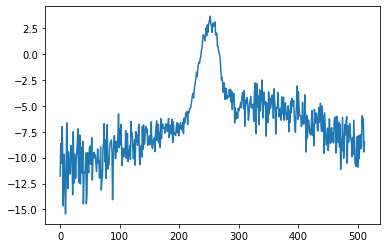

In [56]:
plt.plot(pred_distributions[60])

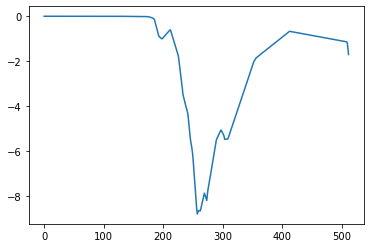

In [58]:
plt.plot(pred_distributions[60])

In [17]:
model_name = 'ebm-512-s1'
model_type = 'pilotnet-ebm'

expert_ds.transform = transforms.Compose([nv.NvidiaCropWide(), nv.Normalize()])
intersection_dataset = crop_place(expert_ds, expert_back_ds)
loader = DataLoader(intersection_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

pred_angles, true_angles, pred_distributions = get_full_model_outputs(model_name, model_type, loader)

print(pred_angles.shape)
print(true_angles.shape)
print(pred_distributions.shape)


100%|██████████| 5/5 [00:09<00:00,  1.86s/it]

(151, 1)
(151,)
(151, 512)


In [28]:
model_name = 'ebm-spatial-0-s2'
model_type = 'pilotnet-ebm'

expert_ds.transform = transforms.Compose([nv.NvidiaCropWide(), nv.Normalize()])
intersection_dataset = crop_place(expert_ds, expert_back_ds)
loader = DataLoader(intersection_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

pred_angles, true_angles, pred_distributions_spatial = get_full_model_outputs(model_name, model_type, loader)

print(pred_angles.shape)
print(true_angles.shape)
print(pred_distributions.shape)


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]

(151, 1)
(151,)
(151, 512)


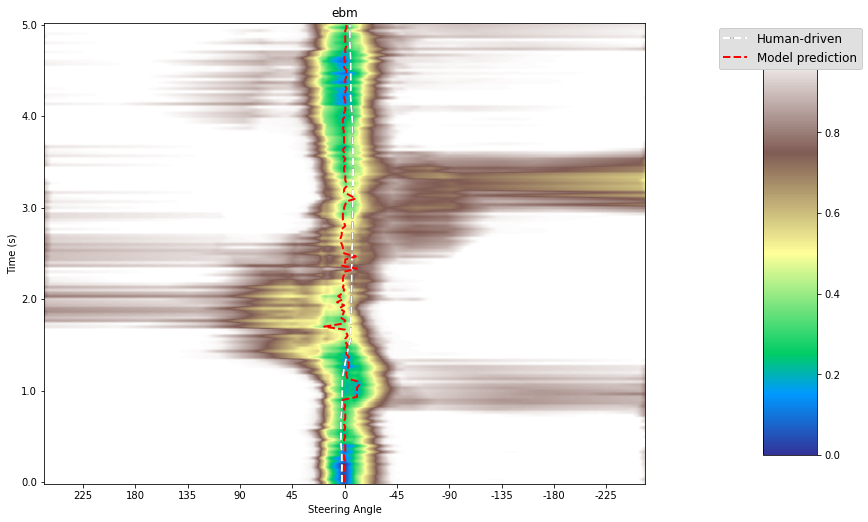

In [20]:
fig, ax = plt.subplots(1, figsize=(15, 8))


mappable = plot_pred_distribution(ax, pred_distributions, pred_angles, true_angles, model_type, 'ebm')

# fig.legend(facecolor='#e0e0e0', framealpha=1)

fig.subplots_adjust(right=0.8, hspace=0.2, wspace=0.2, bottom=0.1, top=0.9)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(mappable, cax=cbar_ax)

handles, labels = ax.get_legend_handles_labels()
cbar_ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.075), ncol=1, facecolor='#e0e0e0', framealpha=1, prop={'size': 12})


plt.show()

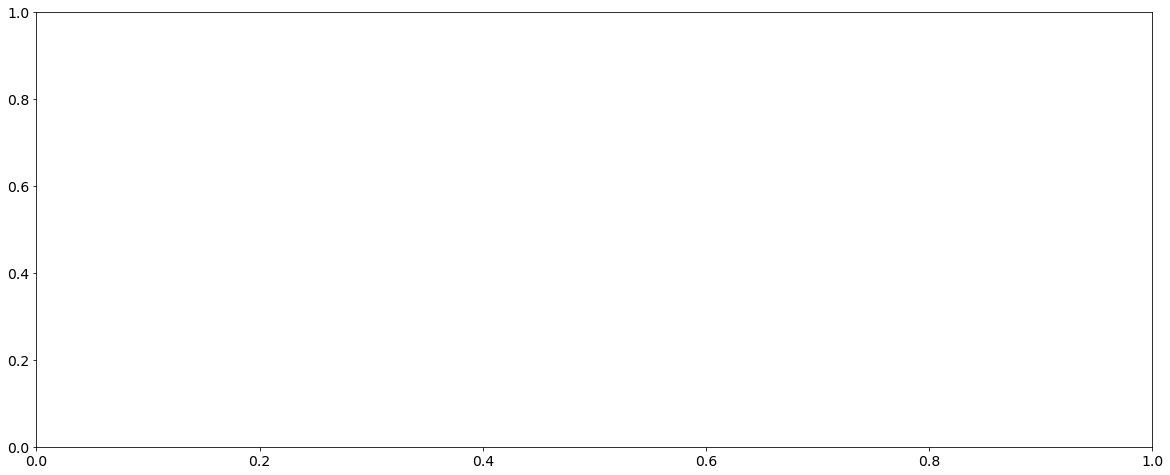

In [29]:
fig, ax = plt.subplots(1, figsize=(20,8))

# make a video from the energy plots, using cv2
import cv2
import glob
import os


def make_video(images, outvid=None, fps=5, size=None,):
    """
    Create a video from a list of images.

    @param      images      list of images to use in the video
    @param      outvid      output video
    @param      fps         frame per second
    @param      size        size of each frame
    @return                 Nothing
    """
    if not outvid:
        outvid = 'outvid.avi'
    if not size:
        size = images[0].shape[1], images[0].shape[0]
    out = cv2.VideoWriter(outvid, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

    for image in images:
        out.write(image)
    out.release()

os.makedirs('video_tmp', exist_ok=True)

for idx in range(45, 60):

    tick_formatter = FuncFormatter(lambda x, pos: int(bin_idx_to_steering_angle(x, num_samples=512, bound=4.5).round()))
    bin_indices = steering_angle_to_bin_idx(np.concatenate([np.arange(0.5, -250, -45),(np.arange(0.5, 250, 45))]))
    tick_locator = FixedLocator(bin_indices)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.xaxis.set_major_locator(tick_locator)
    ax.set_title(f'Step {idx} ({idx/30:.2f}sec)', fontsize=16)


    ax.plot(np.arange(pred_distributions.shape[1]), pred_distributions[idx], label='normal')
    ax.vlines(np.argmin(pred_distributions[idx]), np.min(pred_distributions[idx]), 0, color='lightblue', label='normal prediction', linestyle='--')

    ax.plot(np.arange(pred_distributions_spatial.shape[1]), pred_distributions_spatial[idx], label='spatial')
    ax.vlines(np.argmin(pred_distributions_spatial[idx]), np.min(pred_distributions_spatial[idx]), 0, color='orange', label='spatial prediction', linestyle='--')


    ax.invert_xaxis()
    ax.legend()
    fig.savefig('video_tmp/energy_%d.png' % idx)
    ax.clear()

images = [cv2.imread(file) for file in sorted(glob.glob('video_tmp/energy_*.png'), key=lambda x: int(x.split('_')[-1].split('.')[0]))]
make_video(images, outvid='energy_video_intersection.mp4', fps=3)

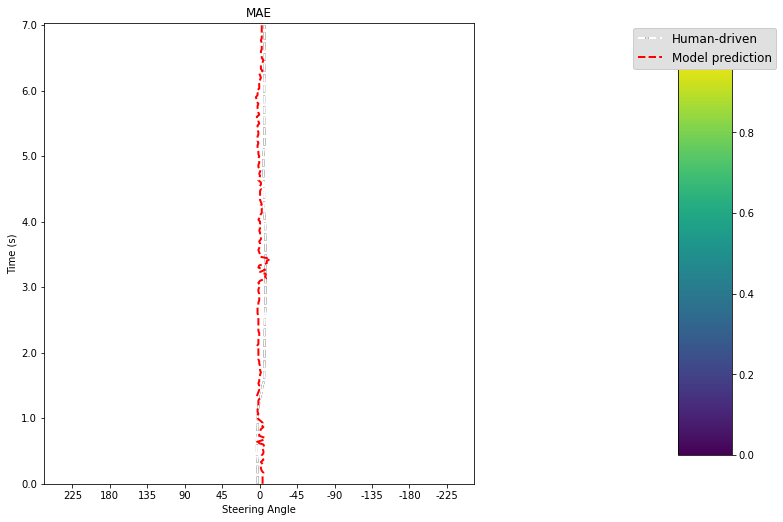

In [391]:
fig, ax = plt.subplots(1, figsize=(15, 8))


model_names = df.groupby('model_name').first()

model_type = 'pilotnet'
model_label = 'MAE'

mappable = plot_pred_distribution(ax, pred_distributions, pred_angles, true_angles, model_type, model_label)

# fig.legend(facecolor='#e0e0e0', framealpha=1)

fig.subplots_adjust(right=0.8, hspace=0.2, wspace=0.2, bottom=0.1, top=0.9)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(mappable, cax=cbar_ax)

handles, labels = ax.get_legend_handles_labels()
cbar_ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.075), ncol=1, facecolor='#e0e0e0', framealpha=1, prop={'size': 12})


plt.show()